# Insurance premium prediction using regression analysis

## Project Documentation

### Overview
A machine learning project to predict health insurance charges based on customer demographics and health factors.

- Analyzed a dataset of 1,337 insurance records with customer age, BMI, smoking status, family size, and regional data.
- Performed comprehensive data preprocessing including duplicate removal, feature encoding, and normalization.
- Applied statistical feature selection to identify the most significant predictors of insurance costs.
- Built and validated a linear regression model to predict insurance premiums.
- Conducted statistical significance testing to optimize model performance and interpretability.

### Results
- Achieved 78% variance explanation (R² = 0.780) with final optimized model using 5 key features.
- Identified smoking status as the primary cost driver, increasing premiums by approximately \$23,040.
- Found age and BMI as secondary significant factors, each contributing ~\$11,600 per standardized unit increase.
- Improved model parsimony by removing 3 statistically insignificant features without performance loss.
- Delivered a production-ready model with RMSE of $5,961, suitable for insurance pricing applications.

### Importing required modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm

### Exploratory Data Analysis (EDA)

In [2]:
df = pd.read_csv('insurance.csv')

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
df.duplicated().sum()

np.int64(1)

In [6]:
df[df.duplicated(keep = False)]

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


In [7]:
df.drop_duplicates(inplace = True)

In [8]:
df.shape

(1337, 7)

#### understanding correlation between numeric features and outcome variable

In [9]:
dfnums = df.select_dtypes(include = 'number')

In [10]:
dfnums.head()

,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520


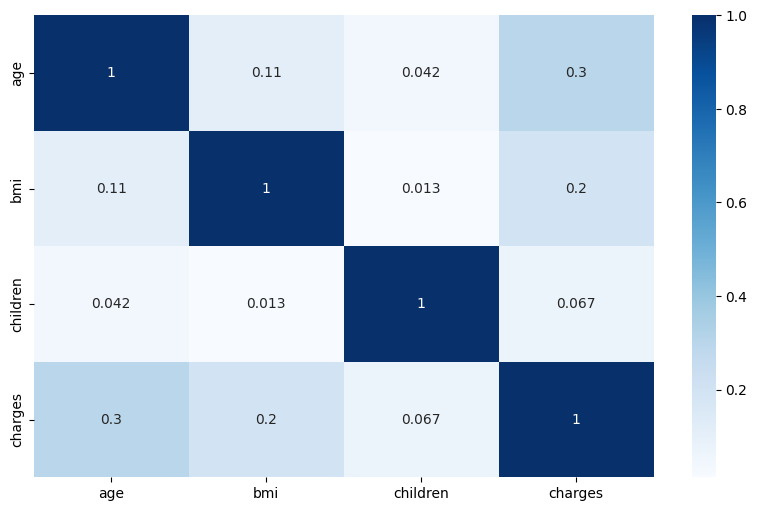

In [11]:
plt.figure(figsize=(10,6))
sns.heatmap(dfnums.corr(), annot=True, cmap='Blues')
plt.show()

#### pre-modelling one hot encoding for categorical features

In [12]:
dfcat = df.select_dtypes(include='object')

In [13]:
dfcat.columns

Index(['sex', 'smoker', 'region'], dtype='object')

In [14]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output = False).set_output(transform='pandas')
transformed = encoder.fit_transform(dfcat)
transformed

,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1333,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1334,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1335,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1336,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [15]:
#dropping redandunt columns and one category from each to prevent dummy variable trap
df = pd.concat([df,transformed], axis=1).drop(columns=['sex','smoker','region','sex_female','smoker_no','region_northeast'])

In [16]:
df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0.0,1.0,0.0,0.0,1.0
1,18,33.770,1,1725.55230,1.0,0.0,0.0,1.0,0.0
2,28,33.000,3,4449.46200,1.0,0.0,0.0,1.0,0.0
3,33,22.705,0,21984.47061,1.0,0.0,1.0,0.0,0.0
4,32,28.880,0,3866.85520,1.0,0.0,1.0,0.0,0.0


#### outliers analysis

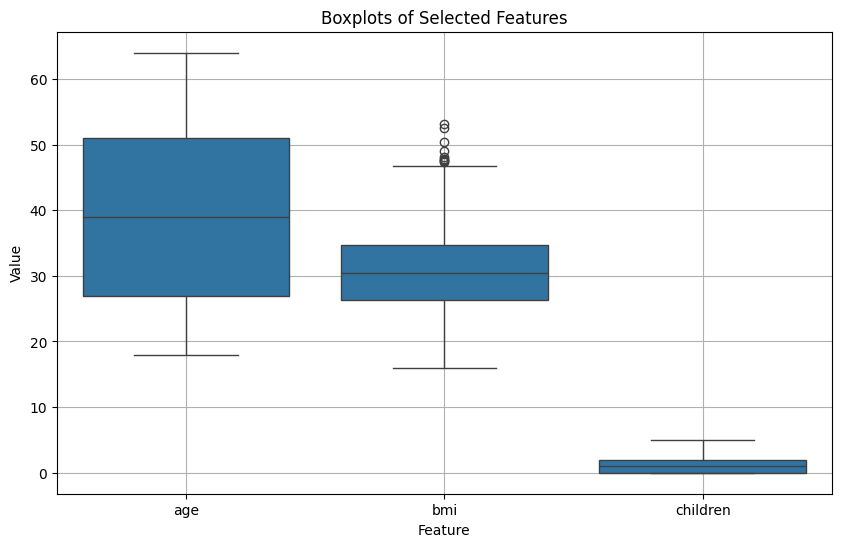

In [17]:
dfnums.drop(columns=['charges'], inplace=True)
cols = dfnums.columns
df_melted = dfnums[cols].melt(var_name='Feature', value_name='Value')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Feature', y='Value', data=df_melted)
plt.title("Boxplots of Selected Features")
plt.grid(True)
plt.show()

In [18]:
col = 'bmi'
Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

rows = df[(df[col] < lower) | (df[col] > upper)]
outliers = rows.shape[0]
percentage = round((outliers/df.shape[0]) * 100, 2)

print(f"number of outliers in col bmi: {outliers}")
print(f"percentage: {percentage}%")

number of outliers in col bmi: 9
percentage: 0.67%


In [19]:
df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0.0,1.0,0.0,0.0,1.0
1,18,33.770,1,1725.55230,1.0,0.0,0.0,1.0,0.0
2,28,33.000,3,4449.46200,1.0,0.0,0.0,1.0,0.0
3,33,22.705,0,21984.47061,1.0,0.0,1.0,0.0,0.0
4,32,28.880,0,3866.85520,1.0,0.0,1.0,0.0,0.0


### Model workflow

#### feature selection

In [20]:
X = df.drop(columns='charges')
X.head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,0.0,1.0,0.0,0.0,1.0
1,18,33.770,1,1.0,0.0,0.0,1.0,0.0
2,28,33.000,3,1.0,0.0,0.0,1.0,0.0
3,33,22.705,0,1.0,0.0,1.0,0.0,0.0
4,32,28.880,0,1.0,0.0,1.0,0.0,0.0


In [21]:
#converting data type to ensure feature scaling compatibility
X['age'] = X['age'].astype('float')
X['children'] = X['children'].astype('float')

In [22]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1337 non-null   float64
 1   bmi               1337 non-null   float64
 2   children          1337 non-null   float64
 3   sex_male          1337 non-null   float64
 4   smoker_yes        1337 non-null   float64
 5   region_northwest  1337 non-null   float64
 6   region_southeast  1337 non-null   float64
 7   region_southwest  1337 non-null   float64
dtypes: float64(8)
memory usage: 94.0 KB


In [23]:
y = df['charges']
y.head()

0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
Name: charges, dtype: float64

#### train-test split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

#### feature scaling

In [25]:
scaler = MinMaxScaler(feature_range=(0,1))

In [26]:
X_train.iloc[:,0:3] = scaler.fit_transform(X_train.iloc[:,0:3])
X_train.head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
630,0.760870,0.531048,0.2,1.0,0.0,0.0,0.0,1.0
556,0.608696,0.457800,0.2,1.0,0.0,0.0,0.0,0.0
427,0.000000,0.340080,0.0,0.0,0.0,0.0,0.0,0.0
1179,0.282609,0.357841,0.0,1.0,1.0,0.0,1.0,0.0
98,0.826087,0.086328,0.0,1.0,1.0,0.0,0.0,0.0


In [27]:
#applying same scaling as X_train
X_test.iloc[:,0:3] = scaler.transform(X_test.iloc[:,0:3])
X_test.head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
748,0.630435,0.528294,0.2,0.0,0.0,0.0,0.0,1.0
634,0.717391,0.630180,0.2,1.0,0.0,0.0,0.0,1.0
652,0.652174,0.394190,0.0,0.0,0.0,0.0,1.0,0.0
411,0.565217,0.094176,0.2,0.0,1.0,0.0,0.0,0.0
502,0.717391,0.176098,0.2,1.0,1.0,0.0,1.0,0.0


#### Model instantiation

In [28]:
model = LinearRegression()

In [29]:
#training model
model.fit(X_train, y_train)

LinearRegression()

In [30]:
#testing model
y_pred = model.predict(X_test)

#### Model evaluation

In [31]:
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
print(f"r2 score: {r2}")
print(f"RMSE: {rmse}")

r2 score: 0.7604434604305353
RMSE: 5942.817265497792


#### OLS analysis

In [32]:
X_train_const = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_train_const)
ols_results = ols_model.fit()
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     393.0
Date:                Fri, 20 Jun 2025   Prob (F-statistic):          7.81e-311
Time:                        13:05:08   Log-Likelihood:                -10830.
No. Observations:                1069   AIC:                         2.168e+04
Df Residuals:                    1060   BIC:                         2.172e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1677.4729    654.822  

### Key findings
- Smoking status emerged as the dominant predictor, contributing approximately \$23,070 to insurance charges - the single most impactful factor.
- Age and BMI showed strong positive relationships with insurance costs, each contributing over $11,000 per standardized unit increase.
- Gender showed no significant impact on insurance premiums (p-value = 0.913), suggesting equitable pricing across sexes.
- Regional differences were minimal, with most regions showing non-significant effects on premium calculations.
- Model achieved strong predictive power with R² of 0.746, explaining 74% of variance in insurance charges across all demographic factors.

### Model refinement

In [33]:
X_train.head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
630,0.760870,0.531048,0.2,1.0,0.0,0.0,0.0,1.0
556,0.608696,0.457800,0.2,1.0,0.0,0.0,0.0,0.0
427,0.000000,0.340080,0.0,0.0,0.0,0.0,0.0,0.0
1179,0.282609,0.357841,0.0,1.0,1.0,0.0,1.0,0.0
98,0.826087,0.086328,0.0,1.0,1.0,0.0,0.0,0.0


#### dropping insignificant features

In [34]:
X_train.drop(columns = ['sex_male', 'region_northwest', 'region_southwest'], inplace=True)
X_test.drop(columns = ['sex_male', 'region_northwest', 'region_southwest'], inplace=True)

In [35]:
X_train.head()

,age,bmi,children,smoker_yes,region_southeast
630,0.760870,0.531048,0.2,0.0,0.0
556,0.608696,0.457800,0.2,0.0,0.0
427,0.000000,0.340080,0.0,0.0,0.0
1179,0.282609,0.357841,0.0,1.0,1.0
98,0.826087,0.086328,0.0,1.0,0.0


In [36]:
X_test.head()

,age,bmi,children,smoker_yes,region_southeast
748,0.630435,0.528294,0.2,0.0,0.0
634,0.717391,0.630180,0.2,0.0,0.0
652,0.652174,0.394190,0.0,0.0,1.0
411,0.565217,0.094176,0.2,1.0,0.0
502,0.717391,0.176098,0.2,1.0,1.0


#### Model instantiation

In [37]:
model.fit(X_train, y_train)

LinearRegression()

In [38]:
y_pred = model.predict(X_test)

#### Model evaluation

In [39]:
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
print(f"r2 score: {r2}")
print(f"RMSE: {rmse}")

r2 score: 0.7607527881295199
RMSE: 5938.979190785481


#### OLS analysis

In [40]:
X_train_const = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_train_const)
ols_results = ols_model.fit()
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     627.6
Date:                Fri, 20 Jun 2025   Prob (F-statistic):          3.70e-314
Time:                        13:05:08   Log-Likelihood:                -10832.
No. Observations:                1069   AIC:                         2.168e+04
Df Residuals:                    1063   BIC:                         2.171e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1915.7250    556.572  

### Final findings
- Maintained predictive accuracy while improving model simplicity - achieved R² of 0.746 with only 5 features compared to 8 in the initial model.
- Smoking status confirmed as the strongest predictor, contributing \$23,040 to insurance charges - validating its critical role in premium determination.
- Age, BMI, and number of children emerged as the core demographic drivers, with age and BMI each adding approximately \$11,600 per unit increase.
- Successfully eliminated statistical noise by removing gender and most regional variables without any loss in predictive performance (RMSE remained ~$5,938).
- Created a more robust, interpretable model with less parameters reducing overfitting risk and maintaining the same 76% variance  for practical deployment.